In [1]:
from torch import nn
import torch
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import numpy as np

import pickle
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
with open('dataset.pickle', 'rb') as handle:
    ds_file = pickle.load(handle)

In [4]:
ds_file.keys()

dict_keys(['treino', 'validacao', 'teste'])

In [5]:
len(ds_file['teste'])

200

In [6]:
ds_file['treino']

['cat.10.jpg',
 'cat.10005.jpg',
 'cat.10008.jpg',
 'cat.10014.jpg',
 'cat.10017.jpg',
 'cat.10018.jpg',
 'cat.10026.jpg',
 'cat.10052.jpg',
 'cat.10063.jpg',
 'cat.10070.jpg',
 'cat.10073.jpg',
 'cat.10092.jpg',
 'cat.10102.jpg',
 'cat.10103.jpg',
 'cat.10133.jpg',
 'cat.10138.jpg',
 'cat.1014.jpg',
 'cat.10142.jpg',
 'cat.10145.jpg',
 'cat.10165.jpg',
 'cat.10195.jpg',
 'cat.10202.jpg',
 'cat.10206.jpg',
 'cat.1021.jpg',
 'cat.10213.jpg',
 'cat.10217.jpg',
 'cat.10220.jpg',
 'cat.10229.jpg',
 'cat.10231.jpg',
 'cat.10234.jpg',
 'cat.10250.jpg',
 'cat.10259.jpg',
 'cat.1026.jpg',
 'cat.10261.jpg',
 'cat.10284.jpg',
 'cat.1029.jpg',
 'cat.10312.jpg',
 'cat.10315.jpg',
 'cat.10331.jpg',
 'cat.10336.jpg',
 'cat.1036.jpg',
 'cat.10360.jpg',
 'cat.10362.jpg',
 'cat.10369.jpg',
 'cat.10384.jpg',
 'cat.10389.jpg',
 'cat.1039.jpg',
 'cat.10393.jpg',
 'cat.10400.jpg',
 'cat.10402.jpg',
 'cat.10414.jpg',
 'cat.10451.jpg',
 'cat.1046.jpg',
 'cat.10460.jpg',
 'cat.10471.jpg',
 'cat.10481.jpg',
 '

### Dados

In [7]:
class CDdataset(Dataset):
    
    tfms = transforms.Compose([
        transforms.RandomAffine(degrees=(-90,90), translate=(0, 0.15), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    def __init__(self, x):
        self.x = x.copy()
        np.random.shuffle(self.x)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        arq = self.x[i] 
        folder = '../Cats and dogs/data/cats/' if 'cat' in arq else '../Cats and dogs/data/dogs/'
        label = 1 if 'cat' in arq else 0
        imagem = Image.open(folder+arq).resize(2*(256,))
        return self.tfms(imagem), torch.tensor(label)

In [8]:
ds_treino = CDdataset(ds_file['treino'])
ds_val = CDdataset(ds_file['validacao'])
ds_teste = CDdataset(ds_file['teste'])

In [9]:
imagem, label = ds_treino[0]
imagem.numpy().transpose(1,2,0).dtype

dtype('float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


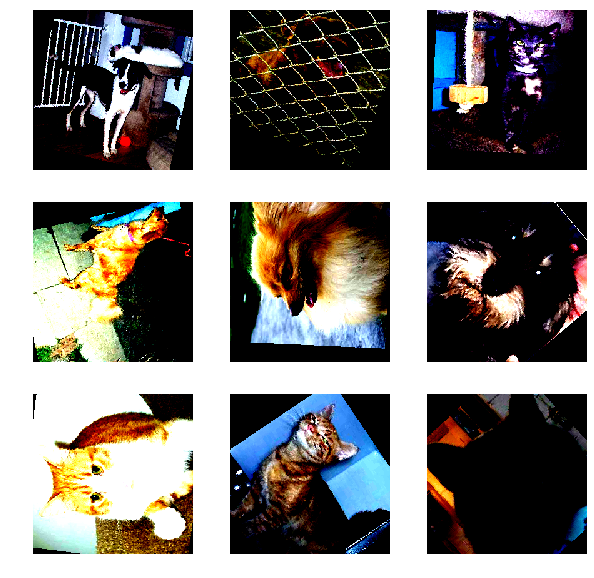

In [10]:
fig,axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))

for i,ax in enumerate(axes.flatten()):
    imagem, label = ds_treino[i]
    ax.imshow(imagem.numpy().transpose(1,2,0))
    #ax.set_title(label)
    ax.axis('off')

In [11]:
dl_treino = DataLoader(ds_treino, batch_size=32, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=16)

In [12]:
t_x, t_y = next(iter(dl_treino))

In [13]:
t_x.shape, t_y.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

### Rede

In [14]:
class Modelo(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.resnet = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-2])
        self.conv1 = nn.Conv2d(in_channels=512,out_channels=256, kernel_size=(4,4))
        self.conv2 = nn.Conv2d(in_channels=256,out_channels=1, kernel_size=(5,5))
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1))
        
        for params in self.resnet.parameters():
            params.requires_grad = False
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        return x.squeeze()

In [15]:
modelo = Modelo()
modelo.to(device)

Modelo(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [16]:
modelo(t_x.to(device)).shape

torch.Size([32])

### Loss, accuracy & optim

In [17]:
from torch import optim

class Otimizador_SGD(optim.Optimizer):
    
    def __init__(self, parametros_modelo, lr):
        
        defaults = dict(lr = lr)
        super().__init__(parametros_modelo, defaults)
        
    def step(self, closure=None):
        
        loss = None
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:  
            
            for p in group['params']:
                if p.grad is None:
                    continue 

                p.data = p.data - self.defaults['lr']*p.grad
    
        return loss    

In [18]:
loss = nn.BCEWithLogitsLoss() 

In [19]:
Otimizador = Otimizador_SGD(parametros_modelo=modelo.parameters(), lr=1e-3)

In [20]:
def accuracy(output, label, theta=0.5):
    p_out = torch.sigmoid(output) > theta
    return (p_out.float() == label.float()).float().mean()    

In [21]:
best_acc = 0.5

In [ ]:
epoch = 10
val_acc = []
val_cost = []
train_cost = []


for i in range(epoch):
    modelo.train()
    
    for t_x, t_y in dl_treino: 
        out = modelo(t_x.to(device))
        Otimizador.zero_grad()
        cost = loss(out, t_y.float().to(device))
        cost.backward()
        Otimizador.step()
        train_cost.append(cost.to('cpu').detach().numpy())
        
    modelo.eval()
    val_custo = 0
    acc = 0
    
    for v_x, v_y in dl_val:
        val_out = modelo(v_x.to(device))
        val_custo += loss(val_out, v_y.float().to(device)).to('cpu').detach().numpy()
        acc += accuracy(val_out.to('cpu'), v_y).numpy()
        
    val_acc.append(acc/len(dl_val))
    val_cost.append(val_custo/len(dl_val))
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        torch.save(modelo.state_dict(), 'CatDog.pt')
        print('novo best_acc')
        
    print(f'Epoca {i+1}: \n Acuracia Validacao: {val_acc[-1]}\n Custo Validacao: {val_cost[-1]}\n')    

novo best_acc
Epoca 1: 
 Acuracia Validacao: 0.9375
 Custo Validacao: 0.3119180832917874



In [ ]:
plt.plot(np.arange(len(train_cost)), train_cost)
#plt.plot(np.arange(len(val_cost)), val_cost)


In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(train_cost)), train_cost)
ax.set_title('Custo treino')
ax.set_xlabel('Iterações')
ax.set_ylabel('Custo')
plt.savefig('CustoTreinoSGD')

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(10,6))
fig.subplots_adjust(wspace=0.5)
ax1.plot(np.arange(len(val_cost)), val_cost)
ax1.set_title('Custo')
ax1.grid('on')
ax1.set_xlabel('Epocas')
ax1.set_ylabel('Custo')
ax2.plot(np.arange(len(val_acc)), val_acc)
ax2.set_title('Acuracia')
ax2.grid('on')
ax2.set_xlabel('Epocas')
ax2.set_ylabel('%')
ax2.set_ylim(top=1)
plt.savefig('CustoValidacaoSGD')

In [ ]:
np.arange(10)

In [ ]:
torch.save(modelo.state_dict(), 'CatDog')

### Teste real

In [ ]:
class DataTeste(Dataset):
    
    path = './animais/'
      
    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    def __init__(self, x):
        self.x = x.copy()
        np.random.shuffle(self.x)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        arq = self.x[i] 
        imagem = Image.open(self.path+arq).resize(2*(256,))
        return self.tfms(imagem)

In [ ]:
import os

In [ ]:
arqs = os.listdir('./animais/')

In [ ]:
ds_real = DataTeste(arqs)

In [ ]:
dl_real = DataLoader(ds_real, batch_size=1)

In [ ]:
dl_iter = iter(dl_real)

In [ ]:
x = next(dl_iter)

out = torch.sigmoid(modelo(x.to(device))).to('cpu').detach().numpy()

plt.imshow(x.squeeze().numpy().transpose(1,2,0))
plt.title(out)
plt.axis('off')
